In [52]:
import pandas as pd
import sys
import os
import datetime
import numpy as numpy

import tensorflow as tf
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

sys.path.insert(0, os.path.abspath('../')) 

from lib.common import constants as k
from lib.common.data_window import DataWindow

train_df = pd.read_csv(k.PROCESSED_DATA_DIR / 'train_data.csv', index_col=0)
test_df  = pd.read_csv(k.PROCESSED_DATA_DIR / 'test_data.csv', index_col=0)
val_df   = pd.read_csv(k.PROCESSED_DATA_DIR / 'val_data.csv', index_col=0)
print(train_df.shape, val_df.shape, test_df.shape)

tf.debugging.disable_traceback_filtering()

(40401, 7) (11543, 7) (5772, 7)


In [53]:
single_step_window = DataWindow(
  input_width=1,
  label_width=1,
  shift=1,
  label_columns=['MarginalEmissions'],
  train_df=train_df,
  test_df=test_df,
  val_df=val_df
)
wide_window = DataWindow(
  input_width=24,
  label_width=24,
  shift=1,
  label_columns=['MarginalEmissions'],
  train_df=train_df,
  test_df=test_df,
  val_df=val_df
)

In [54]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [55]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
baseline_last = Baseline(label_index=column_indices['MarginalEmissions'])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [56]:
val_performance = {}
performance = {}
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

361/361 [==============================] - 0s 820us/step - loss: 2.1076e-04 - mean_absolute_error: 0.0054


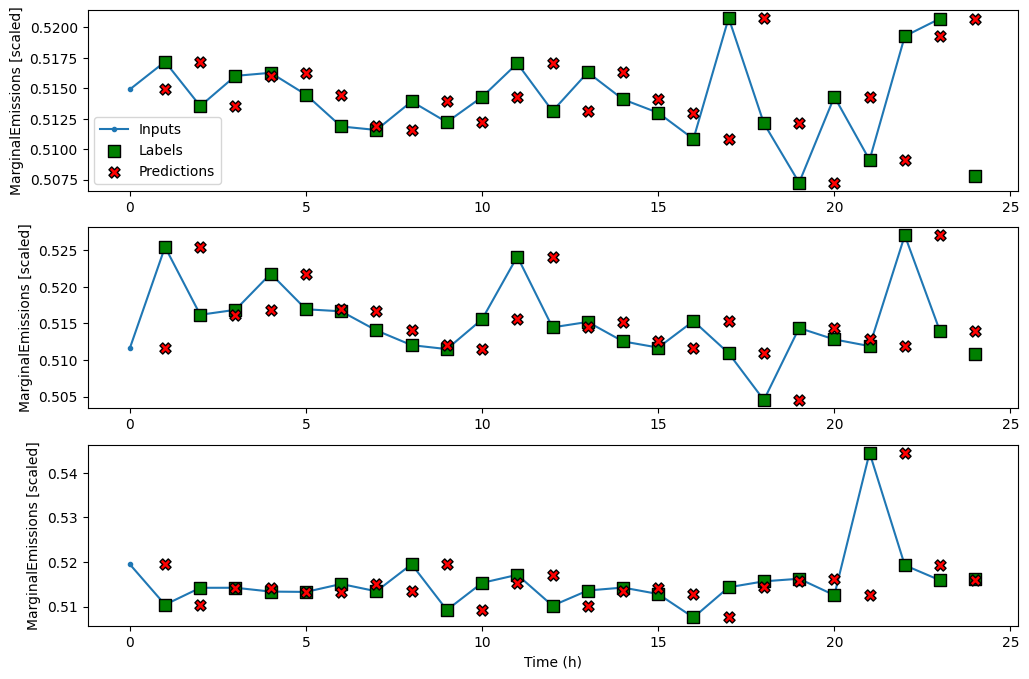

In [65]:
wide_window.plot(baseline_last, plot_col='MarginalEmissions')

In [66]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [68]:
multi_window = DataWindow(
  input_width=24,
  label_width=24,
  shift=24,
  label_columns=['MarginalEmissions'],
  train_df=train_df,
  test_df=test_df,
  val_df=val_df
)

ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['MarginalEmissions'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

360/360 [==============================] - 0s 686us/step - loss: 2.0617e-04 - mean_absolute_error: 0.0055


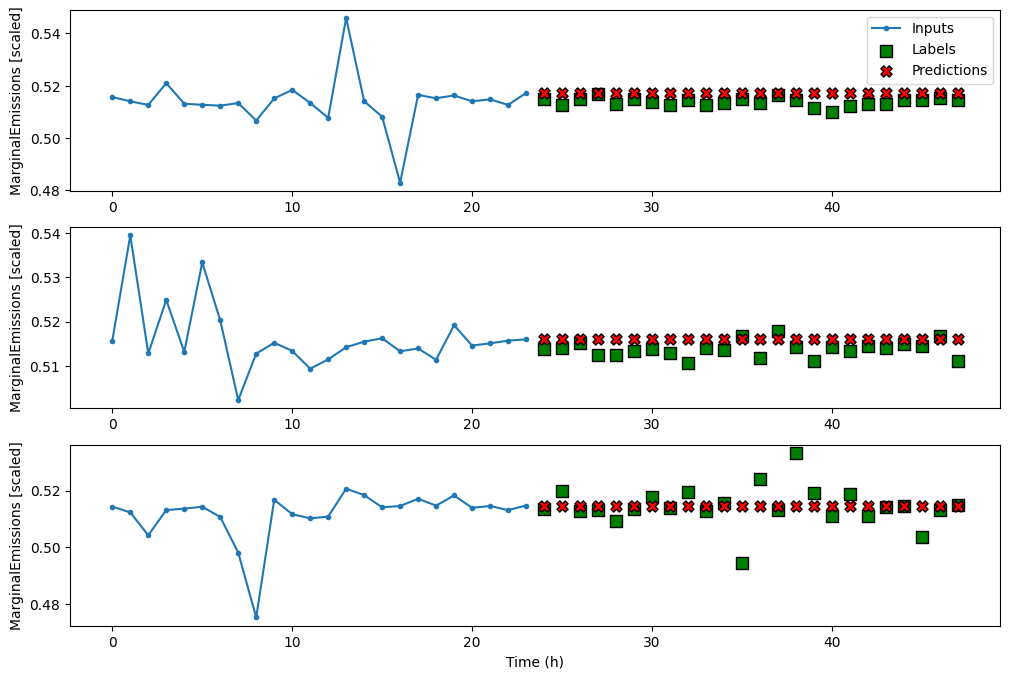

In [70]:
multi_window.plot(ms_baseline_last, plot_col='MarginalEmissions')